In [ ]:
#| default_exp game

# Game

> Easily analyze a single game of pickleball

In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2

In [43]:
#| export
from pklshop.data import *
from pklshop.name import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The Game class is a convienient representation of a single pickleball game. It will calculate basic stats for each player.

In [45]:
#| export
valid_third_shots = {"drop", "drive", "lob"}

In [55]:
#| export
class Game:
    """
    A class to represent a game of pickleball.
    """
    def __init__(self, game_id:str):
        #Create dfs for this game
        self.game_id = game_id
        self.rally = rally[rally.game_id == game_id]
        self.num_rallies = len(self.rally)
        self.game = game[game.game_id == game_id]

        shot_mask = np.isin(shot.rally_id.values, self.rally.rally_id.values)
        self.shot = shot[shot_mask]

        #get the teams and players for this game
        self.w_team_id = self.game[self.game.game_id == self.game_id].w_team_id.values[0]
        self.l_team_id = self.game[self.game.game_id == self.game_id].l_team_id.values[0]
        self.team = team[team.team_id.isin([self.w_team_id, self.l_team_id])]
        self.p1, self.p2 = self.team[self.team.team_id == self.w_team_id].player_id.values #winning players are p1 and p2
        self.p3, self.p4 = self.team[self.team.team_id == self.l_team_id].player_id.values #losing team are p3 and p4

        self.players = players[players.player_id.isin([self.p1, self.p2, self.p3, self.p4])]
        
        self.w_team_name = get_team_name(self.w_team_id, self.team)
        self.l_team_name = get_team_name(self.l_team_id, self.team)

        #get the scores
        self.score_w = self.game[self.game.game_id == self.game_id].score_w.values[0]
        self.score_l = self.game[self.game.game_id == self.game_id].score_l.values[0]

    def __str__(self):
        return "Game({})".format(self.game_id)
    __repr__ = __str__

    def get_error_rate(self, player_id:str) -> float:
        """
        Returns the error rate for a given player in a game.
        """
        num_unforced_errors = sum((self.rally.ending_player_id == player_id) & ((self.rally.ending_type == 'Unforced Error') | (self.rally.ending_type == 'Error')))
        return num_unforced_errors/self.num_rallies
    
    def get_winners_rate(self, player_id:str) -> float:
        """
        Returns the number of winners for a given player in a game.
        """
        return sum((self.rally.ending_player_id == player_id) & (self.rally.ending_type == 'Winner'))/self.num_rallies

    def first_serve_team(self) -> str:
        '''
        Returns the team_id of the team that served first for a given game with game_id.
        '''
        return self.rally[self.rally.rally_nbr == 1].srv_team_id.values[0]

    def first_serve_team_name(self) -> str:
        '''
        Returns the team_id of the team that served first for a given game with game_id.
        '''
        first_team_id = self.first_serve_team()
        return self.get_team_name(first_team_id)
        
    def summarize_game(self) -> None:
        '''
        Prints a summary of the game.
        '''
        print("{} beat {} {}-{} in game {}".format(self.w_team_name, self.l_team_name, self.score_w, self.score_l, self.game_id))

        summary_df = pd.DataFrame({'Player': [get_player_name(p_id, self.players) for p_id in self.players.player_id.values]})
        summary_df['Error %'] = [round(self.get_error_rate(p_id)*100,2) for p_id in self.players.player_id.values]
        summary_df['Winner %'] = [round(self.get_winners_rate(p_id)*100,2) for p_id in self.players.player_id.values]
        print(summary_df.to_string(index=False))
    
    def player_third_shots(self, player_id) -> tuple[int, int, int, int]:
        '''
        Gets the number of eachtype of 3rd shot for a given player in a game
        '''
        player_thirds = self.rally[self.rally.ts_player_id == player_id]
        num_drops = sum(player_thirds.ts_type == 'Drop')
        num_drives = sum(player_thirds.ts_type == 'Drive')
        num_lobs = sum(player_thirds.ts_type == 'Lob')
        num_thirds = num_drops + num_drives + num_lobs

        return num_drops, num_drives, num_lobs, num_thirds
        
    def summarize_third_shots(self) -> None:
        '''
        Summarizes the types of 3rd shots for each player in a game
        '''
        summary_df = pd.DataFrame({'Player': [get_player_name(p_id, self.players) for p_id in self.players.player_id.values]})
        num_drops_arr = []
        num_drives_arr = []
        num_lobs_arr = []
        num_thirds_arr = []
        for player_id in self.players.player_id.values:
            num_drops, num_drives, num_lobs, num_thirds = self.player_third_shots(player_id)
            num_drops_arr.append(num_drops), num_drives_arr.append(num_drives), num_lobs_arr.append(num_lobs), num_thirds_arr.append(num_thirds)
        summary_df['Drops %'] = [round(num_drops_arr[i]/num_thirds_arr[i]*100,2) for i in range(len(num_drops_arr))]
        summary_df['Drives %'] = [round(num_drives_arr[i]/num_thirds_arr[i]*100,2) for i in range(len(num_drops_arr))]
        summary_df['Lobs %'] = [round(num_lobs_arr[i]/num_thirds_arr[i]*100,2) for i in range(len(num_drops_arr))]
        summary_df['Total Thirds'] = num_thirds_arr
        
        print(summary_df.to_string(index=False))

    def third_success_rate(self, ts_type: str) -> tuple[int, int]:
        '''
        Returns the number of 3rd shots of a given type in a game and the number of those shots that were successful, defined
        as resulting in a rally win for the serving team.
        '''
        ts_type = ts_type.lower()
        if ts_type not in valid_third_shots:
            raise ValueError("Invalid third shot type. Valid types are: {}".format(valid_third_shots))
        ts_type = ts_type.title()
        ts_rallies = self.rally[self.rally.ts_type == ts_type]
        num_ts = len(ts_rallies)
        num_success = sum(ts_rallies.srv_team_id == ts_rallies.w_team_id)
        return num_ts, num_success

    def get_winners(self, player_id: str, rally_num: int) -> int:
        '''
        Returns the number of winners for a given player in a game up to a given rally number.
        '''
        return sum((self.rally.ending_player_id == player_id) & (self.rally.ending_type == 'Winner') & (self.rally.rally_nbr <= rally_num))
        
    def get_unforced_errors(self, player_id: str, rally_num: int) -> int:
        '''
        Returns the number of errors for a given player in a game up to a given rally number.
        '''
        return sum((self.rally.ending_player_id == player_id) & (self.rally.ending_type == 'Unforced Error') & (self.rally.rally_nbr <= rally_num))
    
    def get_errors_forced(self, player_id: str, rally_num: int) -> int:
        '''
        Returns the number of errors forced (on the other team) for a given player in a game up to a given rally number.
        '''
        errors_forced = 0
        for r_id in self.rally.rally_id:
            if self.rally[self.rally.rally_id == r_id].rally_nbr.values[0] > rally_num: #only use up to rally_num rallies
                continue
            curr_shots = self.shot[self.shot.rally_id == r_id]
            curr_rally = self.rally[self.rally.rally_id == r_id]
            try:
                penultimate_shot_nbr = max(curr_shots.shot_nbr) - 1 #2nd to last shot number
                penultimate_shot_p_id = curr_shots[curr_shots.shot_nbr == penultimate_shot_nbr].player_id.values[0] #player ID of penultimate shot
            except:
                continue
            if penultimate_shot_p_id == player_id and curr_rally.ending_type.values[0] == 'Error': #if player hit a ball that resulted in an error by other team
                errors_forced += 1
        
        return errors_forced

    def player_impact_flow(self, player_id: str, rally_num: int) -> int:
        '''
        Returns the impact flow for each player up to a given rally number. Defined as winners + errors_forced - unforced errors.
        '''
        return self.get_winners(player_id, rally_num) + self.get_errors_forced(player_id, rally_num) - self.get_unforced_errors(player_id, rally_num)
    
    def plot_impact_flow(self) -> None:
        '''
        Plots the impact flow for each player in a given game. Defined as winners + errors_forced - unforced errors.
        '''
        impact_arr = np.zeros((4, self.num_rallies))
        for rally_num in range(self.num_rallies+1):
            for i, player_id in enumerate(self.players.player_id.values):
                impact_arr[i, rally_num-1] = self.player_impact_flow(player_id, rally_num)
        
        for i, player_id in enumerate(self.players.player_id.values):
            plt.plot(impact_arr[i,:], label=get_player_name(player_id))
        plt.title("Player Impact Flow for Game {}".format(self.game_id))
        plt.xlabel('Rally #')
        plt.legend()
        plt.show()

    def momentum(self) -> int:
        """
       Returns the "momentum" for a given game at each rally. Defined as net number of rallies won up to that point.
        """

        w_team_by_rally = self.rally.sort_values(by='rally_nbr').w_team_id.values
        net = 0
        momentum = np.zeros(len(w_team_by_rally))
        for i, team_id in enumerate(w_team_by_rally):
            if team_id == self.w_team_id:
                net += 1
                momentum[i] = net
            elif team_id == self.l_team_id:
                net -= 1
                momentum[i] = net
            else:
                pass
        return momentum
        
            

In [56]:
g = Game('G40')
g.players

,player_id,first_nm,last_nm,supp_nm,gender,dom_hand,maint_dtm,maint_app,create_dtm,create_app
8,P60,Payton,Noyes,NaN,M,R,2022-11-07 02:44:59.019000+00:00,aspancake,2022-11-07 02:44:59.019000+00:00,aspancake
56,P49,Jon,Smet,NaN,M,R,2022-09-25 03:10:34.044267+00:00,postgres,2022-09-25 03:10:34.044267+00:00,postgres
57,P50,Alex,Spancake,NaN,M,R,2022-09-25 03:10:34.048974+00:00,postgres,2022-09-25 03:10:34.048974+00:00,postgres
69,P59,Mike,Strain,NaN,M,R,2022-11-07 02:44:59.019000+00:00,aspancake,2022-11-07 02:44:59.019000+00:00,aspancake


In [ ]:
show_doc(Game.plot_impact_flow)

---

[source](https://github.com/NolanSmyth/pklshop/blob/main/pklshop/game.py#L153){target="_blank" style="float:right; font-size:smaller"}

### Game.plot_impact_flow

>      Game.plot_impact_flow ()

Plots the impact flow for each player in a given game. Defined as winners + errors_forced - unforced errors.

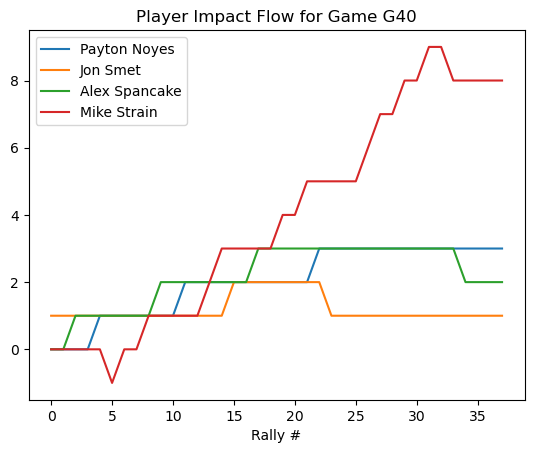

In [ ]:
g.plot_impact_flow() 

In [ ]:
show_doc(Game.summarize_third_shots)

---

[source](https://github.com/NolanSmyth/pklshop/blob/main/pklshop/game.py#L96){target="_blank" style="float:right; font-size:smaller"}

### Game.summarize_third_shots

>      Game.summarize_third_shots ()

Summarizes the types of 3rd shots for each player in a game

In [ ]:
g.summarize_third_shots()

       Player  Drops %  Drives %  Lobs %  Total Thirds
 Payton Noyes    87.50     12.50     0.0             8
     Jon Smet    75.00     25.00     0.0             4
Alex Spancake    33.33     66.67     0.0            12
  Mike Strain    88.89     11.11     0.0             9


In [ ]:
show_doc(Game.summarize_game)

---

[source](https://github.com/NolanSmyth/pklshop/blob/main/pklshop/game.py#L76){target="_blank" style="float:right; font-size:smaller"}

### Game.summarize_game

>      Game.summarize_game ()

In [ ]:
g.summarize_game()

Anna Leigh Waters & Leigh Waters beat Jesse Irvine & Catherine Parenteau 12-10 in game G1
             Player  Error %  Winner %
       Jesse Irvine    17.46      9.52
Catherine Parenteau     1.59      0.00
  Anna Leigh Waters     1.59      3.17
       Leigh Waters     9.52      4.76


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()